In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import ar1_approx as ar
import time
from scipy.optimize import brentq
from math import sqrt
from bisect import bisect_right
#np.set_printoptions(threshold=np.inf)
%matplotlib inline

# Problem 3

### Parameters

In [2]:
# Set parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
betafirm = (1/(1+r))
# Parameters regarding shock
sigma_eps = 0.213
mu = 0.0
rho = 0.7605
sizez = 9

### Capital Stock Grid

In [3]:
# Discretizing the space of capital stock 
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
@jit
def create_K(numb,dens,delta,ub_k):
    for j in range(int(numb * dens)):
        K[j] = ub_k * (1 - delta) ** (j / dens)
    return K

K = create_K(numb,dens,delta,ub_k)
kvec = K[::-1]
sizek = kvec.shape[0]

### Productivity Shocks

In [4]:
# Find the Markov process for the shocks
z_grid, pi = ar.addacooper(sizez,mu,rho,sigma_eps)
z_grid = np.exp(z_grid) #make it to ln

### Profit and Cost Adjustment

In [5]:
def c_prime1(k_1,k_0,psi=1.08,delta=0.154):
    return psi*(k_1/k_0-(1-delta))

def c_prime2(k_1,k_0,psi=1.08,delta=0.154):
    return (psi/2)*((1-delta)**2-(k_1/k_0)**2)

def op_prime2(z,k,alpha_l=0.65,alpha_k=0.297,w=0.7):
    return (alpha_k * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
              (z**(1 / (1 - alpha_l)))*(k ** ((alpha_k/ (1 - alpha_l))-1)))

### Coleman Operator and Policy Function Iteration

In [6]:
def coleman_operator(g, kvec, beta, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek, Kg=None):
    """
    The approximate Coleman operator, which takes an existing guess g of the
    optimal consumption policy and computes and returns the updated function
    Kg on the grid points.  An array to store the new set of values Kg is
    optionally supplied (to avoid having to allocate new arrays at each
    iteration).  If supplied, any existing data in Kg will be overwritten.

    Parameters
    ----------
    g : array_like(float, ndim=2)
        The value of the input policy function on grid points
        Two dimensions to record optimal value given each shock
    kvec : array_like(float, ndim=1)
        The set of capital stock grid points
    beta : scalar
        The discount factor

    """
    # == Initialize Kg if necessary == #
    if Kg is None:
        Kg = np.empty_like(g)

    # == solve for updated consumption value
    for k in range(sizez):
        for i in range(sizek):
            # === Apply linear interpolation to g === #
            g_func = lambda x: np.interp(x, kvec, g[:,k])
            def h(y):
                expected = 0
                for j in range(sizez):
                    expected += pi[k,j]*op_prime2(z_grid[j],y)
                vals = expected + (1-delta) - c_prime2(g_func(y),y)
                return  1+c_prime1(y,kvec[i])-beta*vals
            k_star = brentq(h, 1e-10, 1e3)
            Kg[i,k] = k_star
    return Kg

In [7]:
def compute_pol(g_init, kvec, beta, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek, tol=1e-6, Kg=None):
    g_old = g_init
    err = 100
    iteration = 0
    while err > tol and iteration < 500:
        g_new = coleman_operator(g_old, kvec, beta, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek)
        err = sqrt(np.sum(np.square(g_old-g_new)))
        g_old = g_new
        iteration += 1 
    print("Policy function converged after iteration number:", iteration)
    return g_new

In [8]:
g_init = np.zeros((sizek,sizez))
start_time = time.clock()
g_col = compute_pol(g_init, kvec, betafirm, delta, c_prime1, c_prime2, op_prime2, pi, z_grid, sizez, sizek)
time_1 = time.clock() - start_time
print('PFI took ', time_1, ' seconds to solve')

Policy function converged after iteration number: 75
PFI took  12.589345999999999  seconds to solve


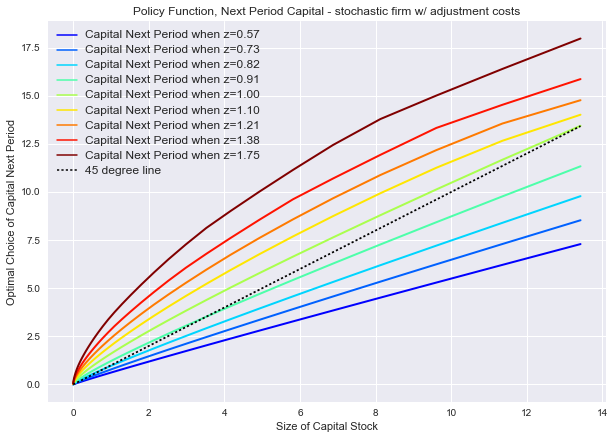

In [9]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(10,7))
for k in range(sizez):
    lb = 'Capital Next Period when z='+format(z_grid[k],'.2f')
    ax.plot(kvec, g_col[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='best', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capital - stochastic firm w/ ' +
          'adjustment costs')
plt.show()

As seen, the policy functions are much smoother since they are roots of the FOC. However, the scale and spread is slightly different than in problem 1 using VFI.

# Finding the Value Function

In [10]:
op = np.zeros((sizek,sizez))
for i in range(sizez):
    op[:,i] = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
          (z_grid[i] ** (1 / (1 - alpha_l)))*((kvec ** alpha_k) ** (1 / (1 - alpha_l))))

e = np.zeros((sizek,sizez))
for i in range(sizek):
    for k in range(sizez):
        e[i,k] = (op[i,k] - g_col[i,k] + ((1 - delta) * kvec[i]) -((psi / 2) * ((g_col[i,k] - ((1 - delta) * kvec[i])) ** 2)/ kvec[i]))
                
def value_iteration(VFdist,VFtol,VFiter,VFmaxiter,V,sizek,sizez,pi,e,betafirm,g,kvec):
    while VFdist > VFtol and VFiter < VFmaxiter:
        TV = np.copy(V)
        for k in range(sizez):  # loop over k
            for i in range(sizek): #loop over z
                expected = 0
                for j in range(sizez):
                    Vfunc = lambda x: np.interp(x,kvec,V[:,j])
                    expected += Vfunc(g[i,j])*pi[k,j]
                V[i,k] = e[i,k] + betafirm*expected
        VFdist = (np.absolute(V - TV)).max()  
        VFiter += 1
    print("Value function converged after iteration number:", VFiter)
    return V

In [11]:
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((sizek,sizez))  # initial guess at value function for z and k
VFiter = 1

start_time = time.clock()
VF = value_iteration(VFdist,VFtol,VFiter,VFmaxiter,V,sizek,sizez,pi,e,betafirm,g_col,kvec)
time_2 = time.clock() - start_time
print('Value function took ', time_2, ' seconds to solve')

Value function converged after iteration number: 200
Value function took  4.115451  seconds to solve


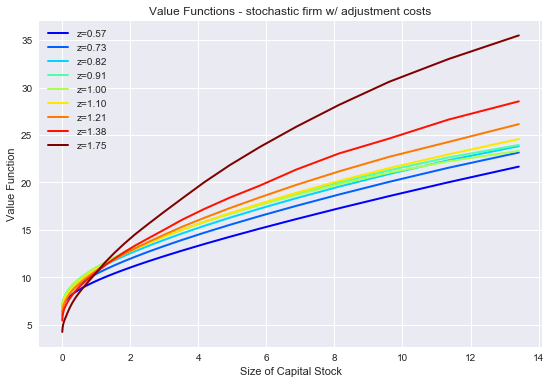

In [12]:
# Plot Value Function for each choice of capital stock and possible shocks
plt.subplots(figsize=(9, 6))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(kvec, VF[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ adjustment costs')
plt.legend(loc='best')
plt.show()

Note that the shapes and spreads are remarkably similar, though the scale is different.